# Classification: Learning Labels of Astronomical Sources
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Danselem/brics_astro/blob/main/Week7/02_classification.ipynb)

Modern astronomy is concerned with the study and characterization of distant objects such as stars, galaxies, or quasars. Objects can often be very quickly characterised through measurements of their optical spectrum. A spectrum is a measure of the photon flux as a function of wavelength.

The spectrum of the star Vega $(\alpha-Lyr)$ with the five filters from the Sloan Digital Sky Survey (SDSS), which are denoted by the letters $u$ (ultraviolet), $g$ (green), $r$ (red), $i$ (infrared), and $z$ (infrared).

The above spectrum is that of the star Vega, the brightest star in the northern constellation Lyra. Its surface is at about 9600 degrees Kelvin, and its spectrum is roughly that of a 9600K black-body, with absorption due to molecules in its cooler atmosphere. The deepest of these absorption spikes are due to the energy levels of Hydrogen. From examination of high-resolution spectra like this one, one can learn a lot about the physical processes at work in a distant astronomical source.

Unfortunately, spectra like these are very time-consuming and expensive to obtain, especially for very faint objects. For this reason, astronomers have long observed objects through broad-band filters, recording the observations using the magnitude system. For the u-band filter shown above, the magnitude is defined as

$$ u = m_{ref} - 2.5 \log_{10}\left[
\int_0^\infty F(\lambda) S(\lambda) d\lambda\right]$$

Here F(\lambda) is the filter transmission, and $S(\lambda)$ is the flux at wavelength $\lambda$. The constant $m_{ref}$ encodes the calibration of the telescope. The reason for the logarithmic form of the magnitude is historical.

Astronomers generally work in terms of the color, defined as the difference of magnitudes between two different filter bands. This is because the constant $m_{ref}$ can be difficult to calibrate from telescope to telescope or from night to night. Subtracting two magnitudes reduces this uncertainty. For example, an observation of the star Vega above will consist of a vector four numbers: $[u-g, g-r, r-i, i-z]$.

Because of this, machine-learning tasks in Astronomy are often based on a small spectroscopic training set, with a larger set of photometric observations with unknown labels or classification. We’ll examine a few of those situations here.

**Note:**
If you are running this jupyter notebook from Colab, then run the next cell by pressing `SHIFT+ENTER` to install the required packages for this notebook. Otherwise, skip the next cell.

In [ ]:
!mkdir -p data
!wget -P data https://raw.githubusercontent.com/Danselem/brics_astro/main/Week7/data/sdss_photoz.npy

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc,
    confusion_matrix, classification_report, RocCurveDisplay, ConfusionMatrixDisplay
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


In [26]:
spec_data = pd.read_csv('data/sdssdr16-class.csv')


spec_data.head()

,objID,RA_ICRS,DE_ICRS,class,umag,gmag,rmag,imag,zmag,spCl,subCl,zph,MJD
0,1237663784217084463,44.991889,0.040779,3,23.202,21.731,20.136,19.498,18.987,GALAXY,NaN,0.3671,52963.2664
1,1237663784217084230,44.997801,0.063080,3,21.739,20.905,20.276,19.973,19.640,GALAXY,STARBURST,0.2365,52963.2664
2,1237663784217084376,44.955188,0.054225,3,21.714,20.851,19.734,19.423,19.272,GALAXY,NaN,0.3736,52963.2664
3,1237663784217084216,44.961076,0.077095,3,21.143,20.027,19.504,19.059,19.022,GALAXY,STARBURST,0.1349,52963.2664
4,1237663784217084075,44.931939,0.077110,3,19.888,18.975,18.607,18.392,18.359,GALAXY,STARBURST,0.1043,52963.2664


In [27]:
spec_data.shape

(450000, 13)

In [28]:
spec_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450000 entries, 0 to 449999
Data columns (total 13 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   objID    450000 non-null  int64  
 1   RA_ICRS  450000 non-null  float64
 2   DE_ICRS  450000 non-null  float64
 3   class    450000 non-null  int64  
 4   umag     450000 non-null  float64
 5   gmag     450000 non-null  float64
 6   rmag     450000 non-null  float64
 7   imag     449999 non-null  float64
 8   zmag     450000 non-null  float64
 9   spCl     450000 non-null  object 
 10  subCl    263711 non-null  object 
 11  zph      162516 non-null  float64
 12  MJD      450000 non-null  float64
dtypes: float64(9), int64(2), object(2)
memory usage: 44.6+ MB


In [29]:
spec_data= spec_data[spec_data['zph'].notna()]

In [30]:
spec_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162516 entries, 0 to 449991
Data columns (total 13 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   objID    162516 non-null  int64  
 1   RA_ICRS  162516 non-null  float64
 2   DE_ICRS  162516 non-null  float64
 3   class    162516 non-null  int64  
 4   umag     162516 non-null  float64
 5   gmag     162516 non-null  float64
 6   rmag     162516 non-null  float64
 7   imag     162516 non-null  float64
 8   zmag     162516 non-null  float64
 9   spCl     162516 non-null  object 
 10  subCl    27049 non-null   object 
 11  zph      162516 non-null  float64
 12  MJD      162516 non-null  float64
dtypes: float64(9), int64(2), object(2)
memory usage: 17.4+ MB


In [31]:
spec_data["spCl"].value_counts()

spCl
GALAXY    140323
QSO        13439
STAR        8754
Name: count, dtype: int64

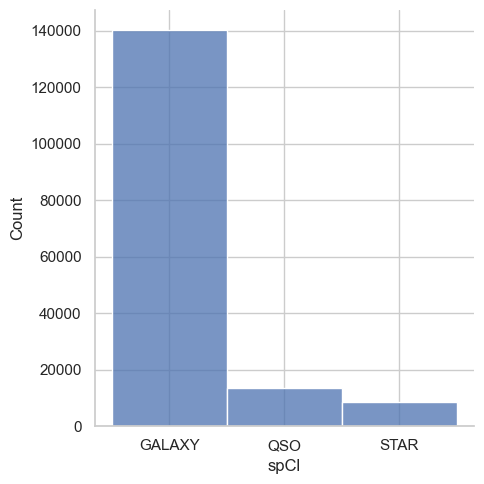

In [32]:
sns.displot(spec_data["spCl"])
plt.show()

In [33]:
spec_data['u-g'] = spec_data['umag'] - spec_data['gmag']
spec_data['g-r'] =spec_data['gmag'] - spec_data['rmag']
spec_data['r-i'] = spec_data['rmag'] - spec_data['imag']
spec_data['i-z'] = spec_data['imag'] - spec_data['zmag']
    


spec_data.head()

,objID,RA_ICRS,DE_ICRS,class,umag,gmag,rmag,imag,zmag,spCl,subCl,zph,MJD,u-g,g-r,r-i,i-z
0,1237663784217084463,44.991889,0.040779,3,23.202,21.731,20.136,19.498,18.987,GALAXY,NaN,0.3671,52963.2664,1.471,1.595,0.638,0.511
1,1237663784217084230,44.997801,0.063080,3,21.739,20.905,20.276,19.973,19.640,GALAXY,STARBURST,0.2365,52963.2664,0.834,0.629,0.303,0.333
2,1237663784217084376,44.955188,0.054225,3,21.714,20.851,19.734,19.423,19.272,GALAXY,NaN,0.3736,52963.2664,0.863,1.117,0.311,0.151
3,1237663784217084216,44.961076,0.077095,3,21.143,20.027,19.504,19.059,19.022,GALAXY,STARBURST,0.1349,52963.2664,1.116,0.523,0.445,0.037
4,1237663784217084075,44.931939,0.077110,3,19.888,18.975,18.607,18.392,18.359,GALAXY,STARBURST,0.1043,52963.2664,0.913,0.368,0.215,0.033


In [34]:
label_encoder = LabelEncoder()
spec_data['label'] = label_encoder.fit_transform(spec_data['spCl'])

print("Class Labels:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

Class Labels: {'GALAXY': np.int64(0), 'QSO': np.int64(1), 'STAR': np.int64(2)}


In [36]:
spec_data['label'] = spec_data['label'].astype('Int64')
spec_data.describe()

,objID,RA_ICRS,DE_ICRS,class,umag,gmag,rmag,imag,zmag,zph,MJD,u-g,g-r,r-i,i-z,label
count,1.625160e+05,162516.000000,162516.000000,162516.0,162516.000000,162516.000000,162516.000000,162516.000000,162516.000000,162516.000000,162516.000000,162516.000000,162516.000000,162516.000000,162516.000000,162516.0
mean,1.237670e+18,92.379428,19.879098,3.0,22.898095,21.217975,19.867106,19.080326,18.653949,0.431925,53737.625343,1.680120,1.350869,0.786779,0.426377,0.190424
std,8.059387e+12,57.331574,10.623694,0.0,2.175848,2.011545,1.842298,1.665427,1.638262,0.217994,979.526571,1.315391,0.596457,0.368562,0.309471,0.511757
min,1.237646e+18,5.304001,0.040779,3.0,10.542000,12.637000,11.066000,10.704000,11.307000,0.000700,51078.414400,-9.476000,-7.747000,-12.301000,-6.251000,0.0
25%,1.237665e+18,26.729008,12.229291,3.0,21.642000,19.832000,18.395000,17.814000,17.447000,0.247500,53081.306100,0.826000,0.933000,0.514000,0.325000,0.0
50%,1.237668e+18,130.348461,18.527169,3.0,23.067000,21.857000,20.346000,19.410000,18.932000,0.477700,53500.182100,1.646000,1.421000,0.789000,0.412000,0.0
75%,1.237679e+18,141.386179,27.694916,3.0,24.439000,22.628000,21.256000,20.164000,19.628000,0.583400,54770.396800,2.320000,1.745000,1.038000,0.548000,0.0
max,1.237681e+18,179.996562,72.357177,3.0,29.899000,28.927000,30.334000,27.763000,27.587000,1.000000,55152.319500,12.480000,11.019000,8.878000,10.754000,2.0


In [37]:

spec_data.label.value_counts()

label
0    140323
1     13439
2      8754
Name: count, dtype: Int64

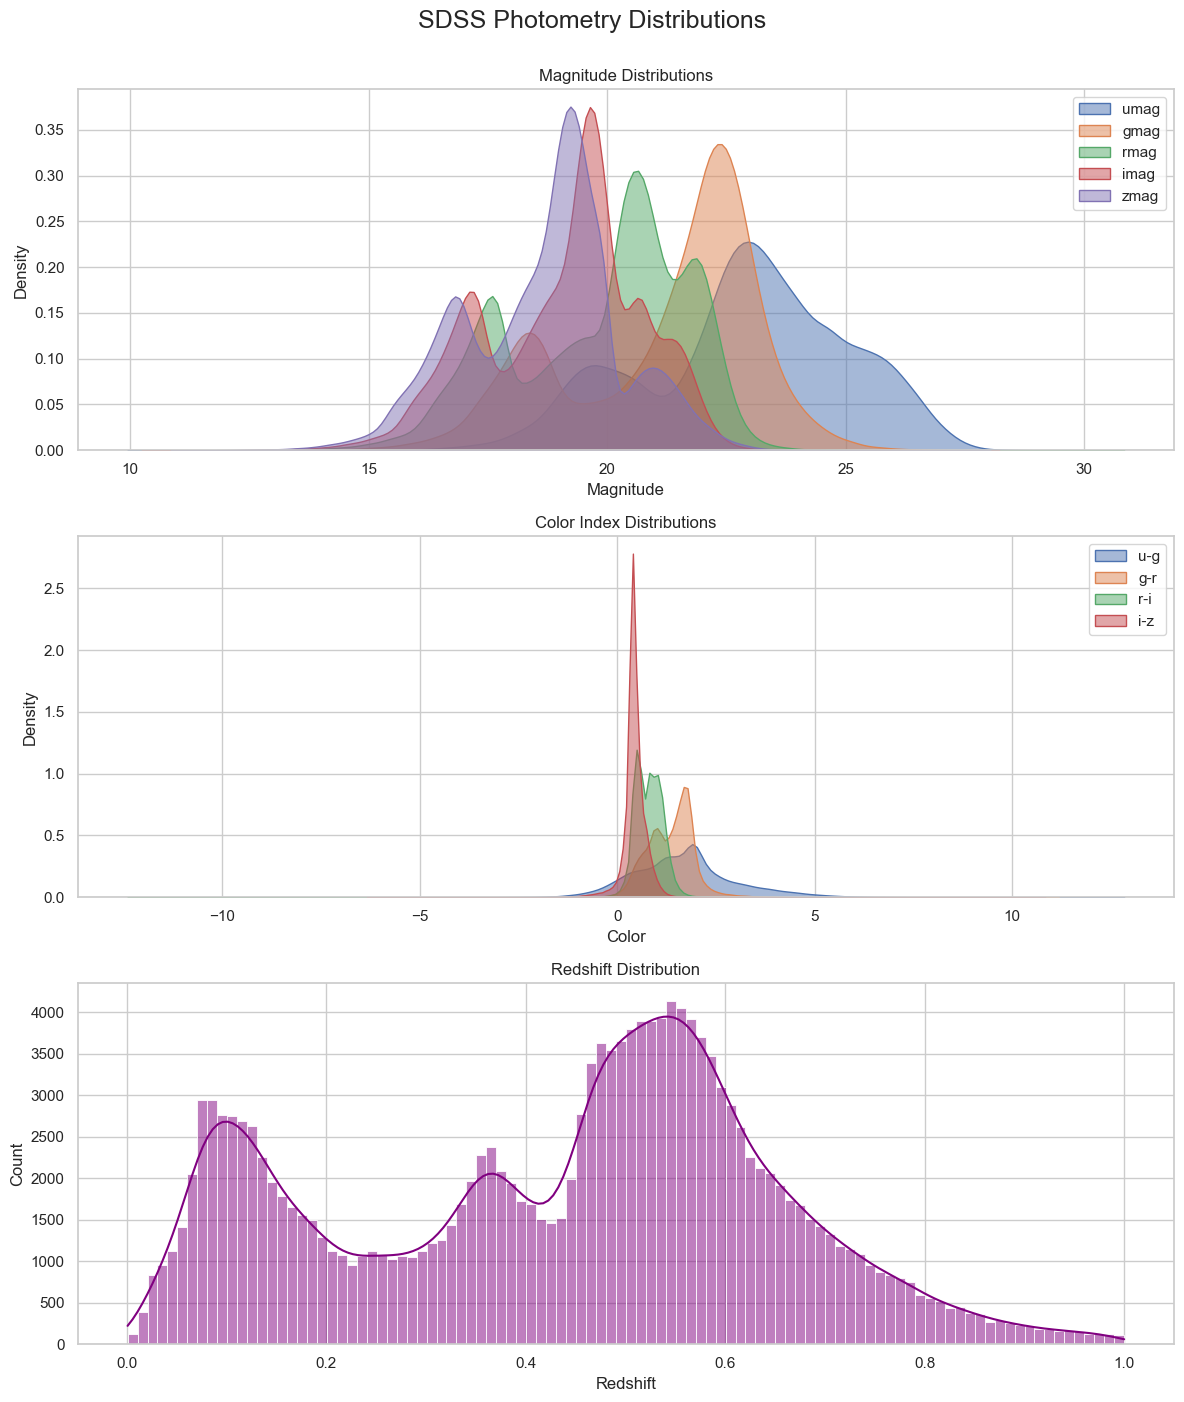

In [38]:
# Set Seaborn theme
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 14))
fig.suptitle('SDSS Photometry Distributions', fontsize=18, y=1)

# 1. Magnitudes
mags = ['umag', 'gmag', 'rmag', 'imag', 'zmag']
for mag in mags:
    sns.kdeplot(spec_data[mag], label=mag, ax=axes[0], fill=True, alpha=0.5)
axes[0].set_title('Magnitude Distributions')
axes[0].set_xlabel('Magnitude')
axes[0].legend()

# 2. Colors
colors = ['u-g', 'g-r', 'r-i', 'i-z']
for color in colors:
    sns.kdeplot(spec_data[color], label=color, ax=axes[1], fill=True, alpha=0.5)
axes[1].set_title('Color Index Distributions')
axes[1].set_xlabel('Color')
axes[1].legend()

# 3. Redshift
sns.histplot(spec_data['zph'], bins=100, kde=True, ax=axes[2], color='purple')
axes[2].set_title('Redshift Distribution')
axes[2].set_xlabel('Redshift')

plt.tight_layout()
plt.show()


In [39]:
features= ['umag', 'gmag', 'rmag', 'imag', 'zmag', 'u-g', 'g-r', 'r-i', 'i-z', 'zph']
label = 'label'

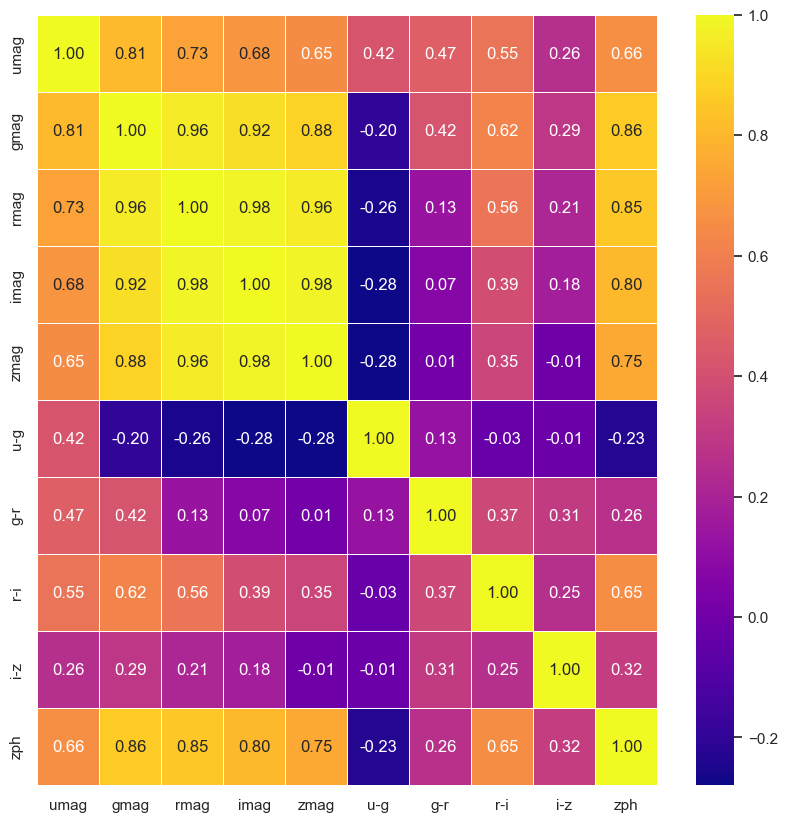

In [40]:
plt.figure(figsize=(10, 10))
sns.heatmap(spec_data[features].corr(), annot = True, fmt = ".2f", linewidths = .5, cmap='plasma')
plt.show()

In [41]:
X = spec_data[features]
y = spec_data[label]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=42)

In [42]:
X_train

,umag,gmag,rmag,imag,zmag,u-g,g-r,r-i,i-z,zph
128605,22.502,22.075,20.475,19.481,18.873,0.427,1.600,0.994,0.608,0.5481
29000,25.714,22.227,22.076,21.144,21.090,3.487,0.151,0.932,0.054,0.3067
398002,21.876,19.178,17.735,17.141,16.776,2.698,1.443,0.594,0.365,0.2316
51715,22.927,20.316,18.632,17.965,17.553,2.611,1.684,0.667,0.412,0.3129
15796,23.577,22.545,20.493,19.547,19.026,1.032,2.052,0.946,0.521,0.5149
...,...,...,...,...,...,...,...,...,...,...
431355,26.231,25.194,22.580,21.570,19.950,1.037,2.614,1.010,1.620,0.4836
18080,25.338,22.649,20.950,19.794,19.464,2.689,1.699,1.156,0.330,0.5717
26100,22.151,21.877,21.861,21.337,22.042,0.274,0.016,0.524,-0.705,0.2669
922,20.002,18.743,18.074,17.677,17.412,1.259,0.669,0.397,0.265,0.1059


In [43]:
def evaluate_pipeline(model, name, X, y, feature_names=None, cv=5):
    print(f"\n{name}")
    print("-" * len(name))

    # Build pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', model)
    ])

    # Cross-validated predictions and probabilities
    y_pred = cross_val_predict(pipeline, X, y, cv=cv, method='predict')
    pipeline.fit(X, y)
    
    print(f"Accuracy (CV): {accuracy_score(y, y_pred):.4f}")
    print(f"Precision: {precision_score(y, y_pred, average='weighted'):.4f}")
    print(f"Recall:    {recall_score(y, y_pred, average='weighted'):.4f}")
    print(f"F1 Score:  {f1_score(y, y_pred, average='weighted'):.4f}")

    print("\nClassification Report:")
    print(classification_report(y, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} — Confusion Matrix')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # Feature importances for tree-based models
    if hasattr(model, "feature_importances_") and feature_names is not None:
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        plt.figure(figsize=(8, 5))
        sns.barplot(x=importances[indices], y=np.array(feature_names)[indices])
        plt.title(f"{name} — Feature Importance")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()

    # Multiclass ROC AUC
    if hasattr(model, "predict_proba"):
        y_proba = cross_val_predict(pipeline, X, y, cv=cv, method="predict_proba")
        class_labels = np.unique(y)
        y_bin = label_binarize(y, classes=class_labels)

        roc_auc = roc_auc_score(y_bin, y_proba, average="weighted", multi_class="ovr")
        print(f"Multiclass ROC AUC (OvR, weighted): {roc_auc:.4f}")

        # Plot ROC curves for each class
        fpr = dict()
        tpr = dict()
        roc_auc_dict = dict()

        plt.figure(figsize=(8, 6))
        for i, label in enumerate(class_labels):
            fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_proba[:, i])
            roc_auc_dict[i] = auc(fpr[i], tpr[i])
            plt.plot(fpr[i], tpr[i], label=f"Class {label} (AUC = {roc_auc_dict[i]:.2f})")

        plt.plot([0, 1], [0, 1], 'k--')
        plt.title(f'{name} — Multiclass ROC Curve')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.tight_layout()
        plt.show()



Random Forest
-------------
Accuracy (CV): 0.8619
Precision: 0.8342
Recall:    0.8619
F1 Score:  0.8409

Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.96      0.92    140323
         1.0       0.35      0.18      0.23     13439
         2.0       0.69      0.32      0.44      8754

    accuracy                           0.86    162516
   macro avg       0.64      0.49      0.53    162516
weighted avg       0.83      0.86      0.84    162516



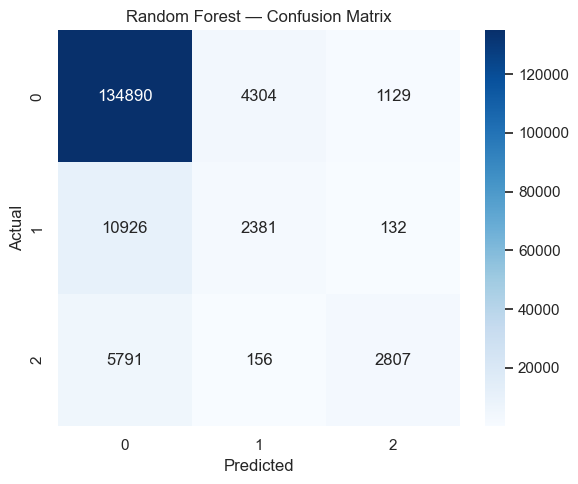

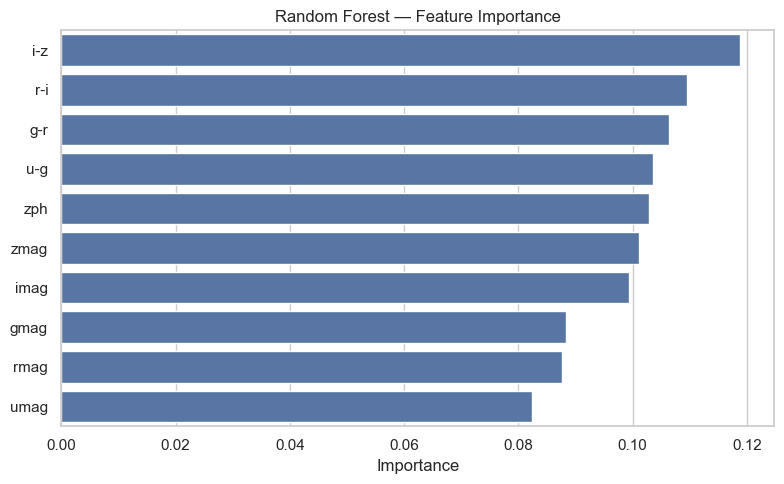

Multiclass ROC AUC (OvR, weighted): 0.8236


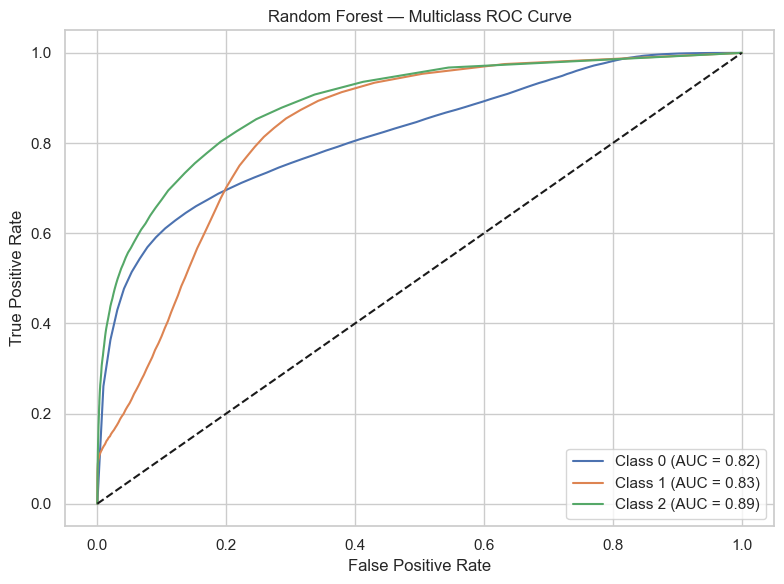


Logistic Regression
-------------------
Accuracy (CV): 0.8480
Precision: 0.7766
Recall:    0.8480
F1 Score:  0.7983

Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.98      0.92    140323
         1.0       0.12      0.03      0.05     13439
         2.0       0.38      0.02      0.04      8754

    accuracy                           0.85    162516
   macro avg       0.45      0.34      0.33    162516
weighted avg       0.78      0.85      0.80    162516



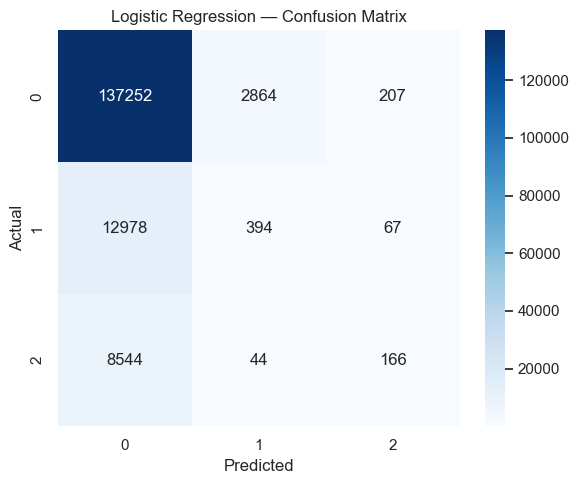

Multiclass ROC AUC (OvR, weighted): 0.7142


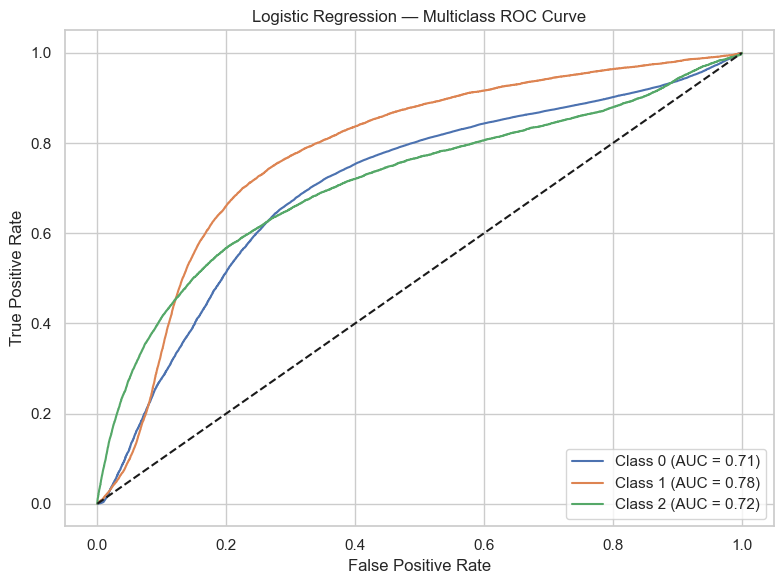


Decision Tree
-------------
Accuracy (CV): 0.8001
Precision: 0.8151
Recall:    0.8001
F1 Score:  0.8072

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.88      0.89    140323
         1.0       0.25      0.31      0.28     13439
         2.0       0.33      0.36      0.34      8754

    accuracy                           0.80    162516
   macro avg       0.49      0.51      0.50    162516
weighted avg       0.82      0.80      0.81    162516



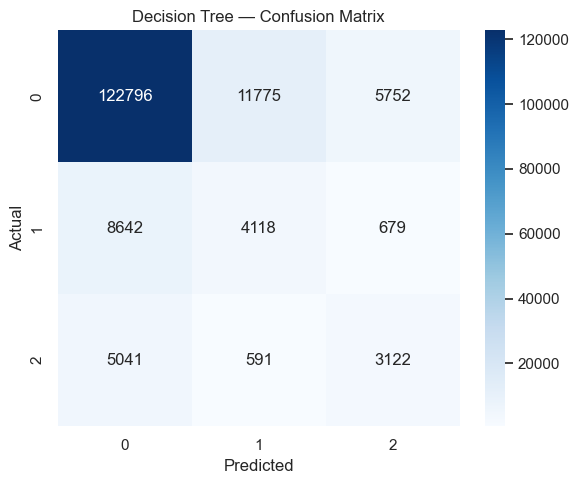

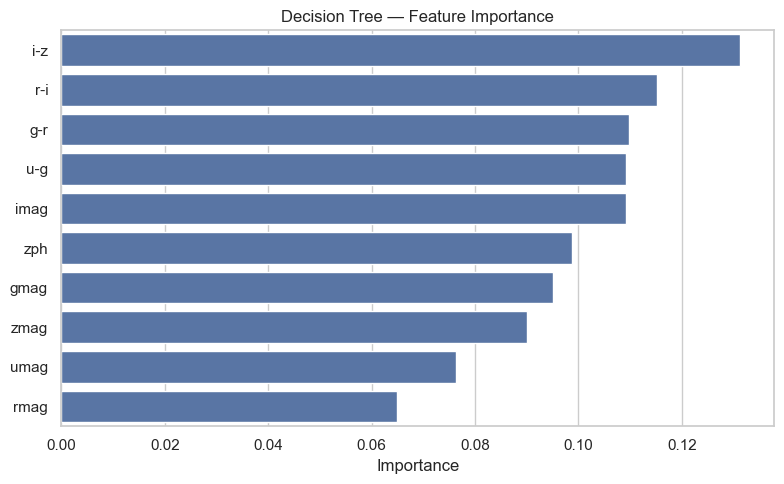

Multiclass ROC AUC (OvR, weighted): 0.6293


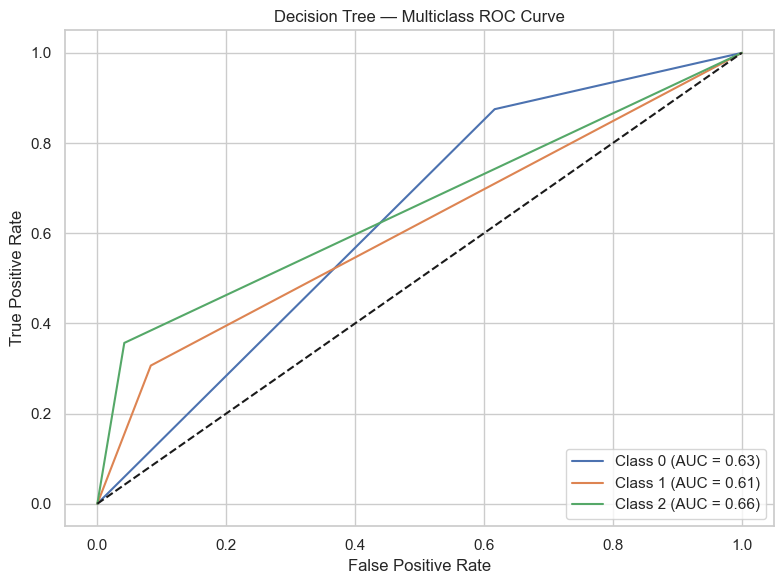


KNN Classifier
--------------
Accuracy (CV): 0.8525
Precision: 0.8283
Recall:    0.8525
F1 Score:  0.8350

Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.95      0.92    140323
         1.0       0.31      0.20      0.25     13439
         2.0       0.64      0.29      0.40      8754

    accuracy                           0.85    162516
   macro avg       0.61      0.48      0.52    162516
weighted avg       0.83      0.85      0.84    162516



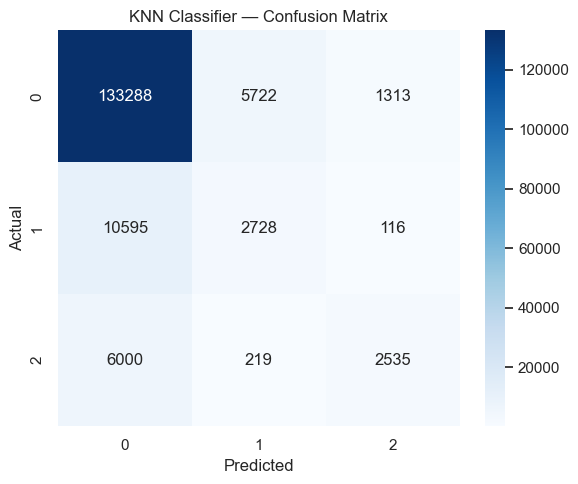

Multiclass ROC AUC (OvR, weighted): 0.7397


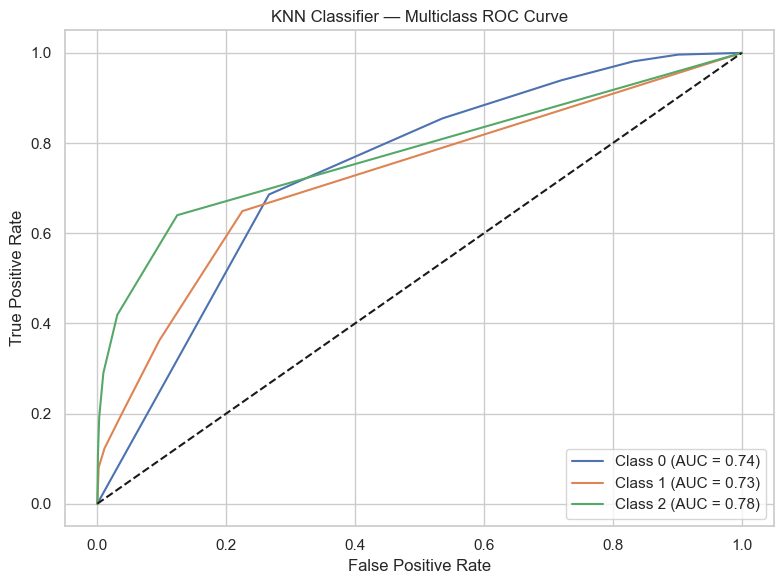


Support Vector Classifier
-------------------------


In [ ]:
classifiers = [
    (RandomForestClassifier(random_state=42), "Random Forest"),
    (LogisticRegression(max_iter=1000), "Logistic Regression"),
    (DecisionTreeClassifier(random_state=42), "Decision Tree"),
    (KNeighborsClassifier(), "KNN Classifier"),
    (SVC(probability=True), "Support Vector Classifier")
]

for model, name in classifiers:
    evaluate_pipeline(model, name, X, y, feature_names=X.columns)
